In [19]:
import pandas as pd
import numpy as np

## Load in and transform 2022 Data (No Nan's)

In [20]:
heart_data = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Adv_ML\Labs\Lab_2\heart_2022_no_nans.csv")
# List of columns to convert to category type
category_columns = [
    'State', 'Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
    'RemovedTeeth', 'HadHeartAttack', 'AlcoholDrinkers', 'HadAngina', 'HadStroke',
    'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
    'HadArthritis','HIVTesting', 'HadDiabetes', 'DeafOrHardOfHearing','BlindOrVisionDifficulty','DifficultyConcentrating',
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan',
    'RaceEthnicityCategory', 'AgeCategory',
    'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]
# Converting the specified columns to 'category' data type
heart_data[category_columns] = heart_data[category_columns].astype('category')

heart_data.head(1)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.6,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No


In [21]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to numeric for XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(heart_data['HadHeartAttack'])

# Splitting the dataset
X = heart_data.drop('HadHeartAttack', axis=1)
y = y_encoded

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=['category','object'])), 
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

## Metric Decision Explanation

Given the medical background and imbalanced nature of the dataset, I am deciding to use and F_Beta (F2) score that slightly prioritizes Recall for the model evaluations below. My thought process is that you would rather prioritize identifying all who are at increased risk of heart attack so that they can make the correct health choices and change their lifestyle. Those who are falsely identified are probably on the edge to begin with, and could benefit from the lifestyle changes regardless. A big caveat here would be if serious medication were to be prescribed, in that case I included the option to adjust the F_Beta value based on the circumstances.

## XGBoost

Going to use the XGBoost scale_pos_weight parameter to account for imbalance in data. I compare the results from the scale position weight parameter to the undersampling technique further below.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Calculating scale_pos_weight to account for imbalance in data
heart_scale_pos_weight = sum(y == 0) / sum(y == 1)

# Define the pipeline with an XGBoost classifier
xgb_pipeline = Pipeline([
    ('preprocessor', ct),
    ('xgb_classifier', XGBClassifier(objective='binary:logistic', use_label_encoder=False, scale_pos_weight= heart_scale_pos_weight, random_state=1))
])

# Hyperparameters to be tested for the XGBoost model
param_grid = {
    'xgb_classifier__max_depth': [8,10,12,14],
    'xgb_classifier__n_estimators': [75,100,150],
    'xgb_classifier__learning_rate': [0.5,1,2]
}

# Create GridSearchCV with multiple scoring metrics and refit based on recall
gscv = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring=['recall', 'precision', 'accuracy'], refit='recall')

gscv.fit(X, y)

# Extracting scores for each metric
recall_scores = gscv.cv_results_['mean_test_recall']
precision_scores = gscv.cv_results_['mean_test_precision']
accuracy_scores = gscv.cv_results_['mean_test_accuracy']
params = gscv.cv_results_['params']

# Creating a dataframe with hyperparameter tuning results
results_df = pd.DataFrame(params)
results_df['Recall'] = recall_scores
results_df['Precision'] = precision_scores
results_df['Accuracy'] = accuracy_scores

# Calculate F_Beta score with weight (beta) based on desired recall/precision weight
beta = 2
results_df['F_Beta'] = (1 + beta**2) * ((results_df['Precision'] * results_df['Recall']) / ((beta**2 * results_df['Precision']) + results_df['Recall']))

# Sort the results by F_beta score in descending order
results_df_sorted = results_df.sort_values(by="F_Beta", ascending=False)
results_df_sorted


c:\Users\broga\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\broga\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\broga\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,xgb_classifier__learning_rate,xgb_classifier__max_depth,xgb_classifier__n_estimators,Recall,Precision,Accuracy,F_Beta
0,0.5,8,75,0.647265,0.233715,0.864699,0.478077
1,0.5,8,100,0.620097,0.244033,0.874186,0.474005
2,0.5,8,150,0.579903,0.264461,0.888827,0.468210
3,0.5,10,75,0.549907,0.272760,0.895184,0.457031
4,0.5,10,100,0.520432,0.293473,0.905195,0.450719
12,1.0,8,75,0.578638,0.234812,0.873767,0.447567
13,1.0,8,100,0.550800,0.249146,0.884620,0.443425
5,0.5,10,150,0.483662,0.325150,0.916674,0.440694
14,1.0,8,150,0.517454,0.272995,0.897981,0.438858
6,0.5,12,75,0.471009,0.328942,0.918406,0.433559


In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBClassifier

# Define the best XGBoost pipeline
best_xgb_pipeline = Pipeline([
    ('preprocessor', ct),
    ('xgb_classifier', XGBClassifier(max_depth=8, n_estimators=75, learning_rate=0.5, objective='binary:logistic', use_label_encoder=False, scale_pos_weight= heart_scale_pos_weight, random_state=1))
])

# Fit the XGBoost model
best_xgb_model = best_xgb_pipeline.fit(X, y)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score

# Create custom scorer for F3 score
f2_scorer = make_scorer(fbeta_score, beta=3)

# Perform cross-validation for precision, recall, and F3 score
precision_scores = cross_val_score(best_xgb_pipeline, X, y, scoring='precision', cv=5)
recall_scores = cross_val_score(best_xgb_pipeline, X, y, scoring='recall', cv=5)
f2_scores = cross_val_score(best_xgb_pipeline, X, y, scoring=f2_scorer, cv=5)

precision_score = precision_scores.mean()
recall_score = recall_scores.mean()
f2_score = f2_scores.mean()

# Output results
print("Cross-validated Precision score: ", precision_score)
print("Cross-validated Recall score: ", recall_score)
print("Cross-validated F2 score: ", f2_score)



Cross-validated Precision score:  0.23371544861633503
Cross-validated Recall score:  0.6472646073688127
Cross-validated F2 score:  0.5498381778298279


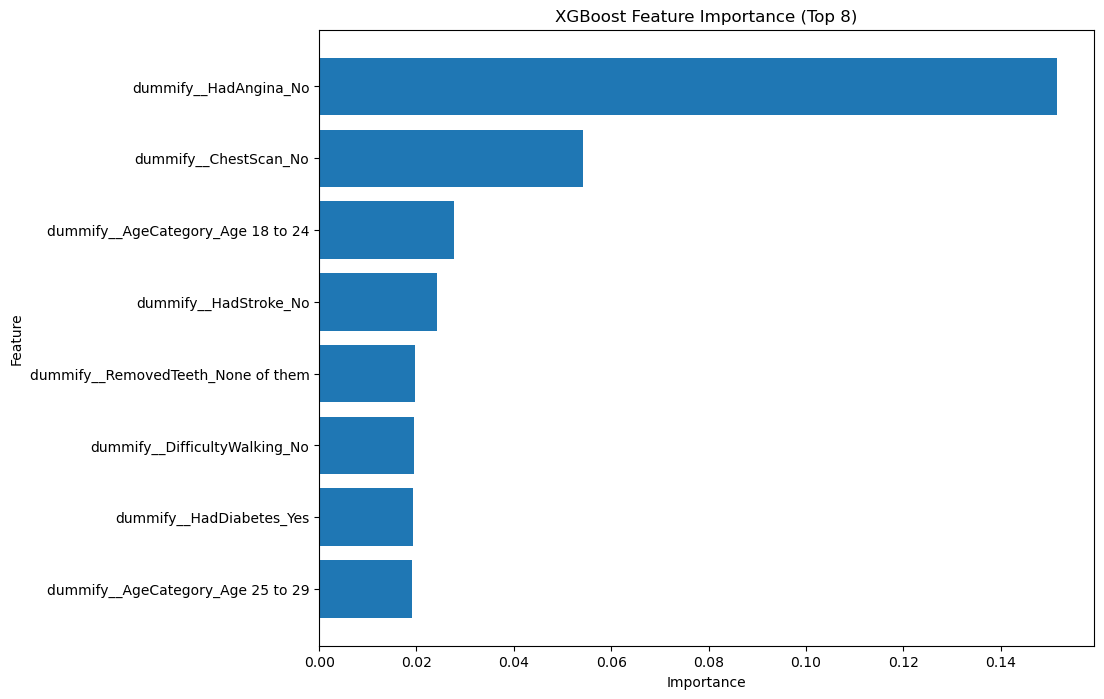

In [25]:
import matplotlib.pyplot as plt

# Extract the XGBoost model from the pipeline
xgb_model = best_xgb_pipeline.named_steps['xgb_classifier']

# Feature importance and names from the model
feature_importances = xgb_model.feature_importances_

feature_names = best_xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier interpretation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by the importance to see the most influential features
feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 5 most important features
top_features = feature_importance_sorted.head(8)

# Plot feature importances for the top 5 features only
plt.figure(figsize=(10, 8))  
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (Top 8)')
plt.gca().invert_yaxis()  
plt.show()


The following features were the most significant: 
- No Angina (heart condition) 
- No Chest Scan
- Age 18 - 24
- No Stroke History
- No Removed Teeth

These features being the most significant make sense intuitively as they are features that are common among healthy (young) individuals who would be less likley to suffer from a heart attack.


## XGBoost + Undersampling

Using Undersampling with an XGBoost model to see if that improves model performance

In [27]:
print("Initial class distribution:")
print(heart_data['HadHeartAttack'].value_counts())

# Perform undersampling
minority_class = heart_data[heart_data['HadHeartAttack'] == 'Yes']
majority_class = heart_data[heart_data['HadHeartAttack'] == 'No']

# Get the number of instances in the minority class
minority_class_count = len(minority_class)

# Sample from the majority class to match the minority class size
majority_class_under = majority_class.sample(minority_class_count)

# Concatenate the down-sampled majority class DataFrame with the minority class DataFrame
balanced_data = pd.concat([majority_class_under, minority_class], axis=0)

# Shuffle the dataset to mix up the rows
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

# Display the new class distribution
print("New class distribution after undersampling:")
print(balanced_data['HadHeartAttack'].value_counts())


Initial class distribution:
No     232587
Yes     13435
Name: HadHeartAttack, dtype: int64
New class distribution after undersampling:
No     13435
Yes    13435
Name: HadHeartAttack, dtype: int64


In [28]:
y_res_encoded = label_encoder.fit_transform(balanced_data['HadHeartAttack'])

#Create new resampled features with undersampled data
X_res = balanced_data.drop('HadHeartAttack', axis=1)
y_res = y_res_encoded

In [29]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=['category','object'])), 
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Define the pipeline with an XGBoost classifier
xgb_pipeline_res = Pipeline([
    ('preprocessor', ct),
    ('xgb_classifier', XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=1))
])

# Hyperparameters to be tested for the XGBoost model
param_grid = {
    'xgb_classifier__max_depth': [8,10,12],
    'xgb_classifier__n_estimators': [75,100,150],
    'xgb_classifier__learning_rate': [0.5,1]
}

# Create GridSearchCV with multiple scoring metrics and refit based on recall
gscv = GridSearchCV(xgb_pipeline_res, param_grid, cv=5, scoring=['recall', 'precision', 'accuracy'], refit='recall')

gscv.fit(X_res, y_res)

# Extracting scores for each metric
recall_scores = gscv.cv_results_['mean_test_recall']
precision_scores = gscv.cv_results_['mean_test_precision']
accuracy_scores = gscv.cv_results_['mean_test_accuracy']
params = gscv.cv_results_['params']

# Creating a dataframe with hyperparameter tuning results
results_df = pd.DataFrame(params)
results_df['Recall'] = recall_scores
results_df['Precision'] = precision_scores
results_df['Accuracy'] = accuracy_scores

# Calculate F_Beta score with weight (beta) based on desired recall/precision weight
beta = 2
results_df['F_Beta'] = (1 + beta**2) * ((results_df['Precision'] * results_df['Recall']) / ((beta**2 * results_df['Precision']) + results_df['Recall']))

# Sort the results by F_beta score in descending order
results_df_sorted = results_df.sort_values(by="F_Beta", ascending=False)
results_df_sorted.head(5)

,xgb_classifier__learning_rate,xgb_classifier__max_depth,xgb_classifier__n_estimators,Recall,Precision,Accuracy,F_Beta
6,0.5,12,75,0.779233,0.787308,0.784332,0.780835
7,0.5,12,100,0.777968,0.786041,0.783067,0.779569
8,0.5,12,150,0.778191,0.784191,0.781987,0.779384
5,0.5,10,150,0.777075,0.786651,0.783141,0.778971
1,0.5,8,100,0.777373,0.782821,0.780834,0.778456


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score

best_xgb_pipeline_res = Pipeline([
    ('preprocessor', ct),
    ('xgb_classifier', XGBClassifier(learning_rate=0.5,max_depth=12,n_estimators=75, objective='binary:logistic', use_label_encoder=False, random_state=1))
])

# Create custom scorer for F3 score
f2_scorer = make_scorer(fbeta_score, beta=2)

# Perform cross-validation for precision, recall, and F3 score
precision_scores = cross_val_score(best_xgb_pipeline_res, X, y, scoring='precision', cv=5)
recall_scores = cross_val_score(best_xgb_pipeline_res, X, y, scoring='recall', cv=5)
f3_scores = cross_val_score(best_xgb_pipeline_res, X, y, scoring=f2_scorer, cv=5)

res_precision_score = precision_scores.mean()
res_recall_score = recall_scores.mean()
res_f2_score = f3_scores.mean()

# Output results
print("Cross-validated Precision score: ", res_precision_score)
print("Cross-validated Recall score: ", res_recall_score)
print("Cross-validated F2 score: ", res_f2_score)


Cross-validated Precision score:  0.4802692100563153
Cross-validated Recall score:  0.25761071827316706
Cross-validated F2 score:  0.28340040995489607


The undersampling performs noticeably worse despite online resources claiming it may be more suitable for larger datasets. The only benefit to using the undersampling method was it increased the computation speed due to smaller size of the data. It seems that Oversampling (SMOTE) or the scale_pos_weight parameter are much more effective based on our metrics above.